# Лекция 4. Домашнее задание.

## Задача 1.

На основании данных портала "Открытые данные России" о результатах Химического анализа родника в Нескучном саду https://data.gov.ru/opendata/7708660670-rodnik-neskuchniy-sad средствами библиотеки Pandas сформируйте поле выводов по каждому анализирумомому параметру. Например, по показателю pH получен результат 8.4 единицы pH при нормативе от 6 до 9 единиц pH. Т.о. по данному показателю результат анализа в норме. Для решения задачи необходимо программно "прочитать и понять" значение столбца "Норматив" и выделенное численное значение сравнить с нормативом согласно логике норматива. Например, 6 >= pH >= 9. В итоговом DataFrame столбец "Показатель" сделайте индексным.

Загзрузка DataFrame выполняется непосредственно c сайта "Открытые данные России" https://data.gov.ru/opendata/7708660670-rodnik-neskuchniy-sad/data-20160608T1215-structure-20160608T1215.csv (см. код ниже).

In [64]:
import requests
import pandas as pd
import numpy as np
import io
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [65]:
url ="https://data.gov.ru/opendata/7708660670-rodnik-neskuchniy-sad/data-20160608T1215-structure-20160608T1215.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('UTF8')))
display(df)

,Показатель,Единица измерений,Результат анализа,Норматив
0,pH,единицы pH,8.4,в пределах 6-9
1,Запах,баллы,1,не более 2-3
2,Цветность,градусы,б/цвета,не более 30
3,Жёсткость,мг-эквл/дм3,9.199999999999999,в пределах 7-10
4,Аммиак и аммоний-ион (по азоту),мг/дм3,0.42,"не более 1,5"
5,Нитриты (по NO2),мг/дм3,0.017,"не более 3,3"
6,Нитраты (по NO3),мг/дм3,24,не более 45
7,Фосфаты (P),мг/дм3,0.36,"не более 3,5"
8,Хлориды (Cl),мг/дм3,200,не более 350
9,Сульфаты (SO4),мг/дм3,189.5,не более 500


In [66]:
between = lambda x, a, b: a <= x <= b
nomore = lambda x, a: x <= a
normatives_dict = {
    "в пределах": between,
    "не более": nomore
}

In [67]:
# Функция обрабатывает сформированную строку "Результат_анализа#Норматив" и возвращает Оценку_результата_анализа
def get_result_verdict(analysis_res_and_normative:str) -> str:
    
     # словарь для нечисловых значений результата анализа
    analysis_results_words_dict = {
        "Цветность": {"б/цвета": 20} # вода без цвета ~20 градусов
    }
    
    try:
        analysis_result = float(analysis_res_and_normative.split("#")[1])
    except Exception:
        metric = analysis_res_and_normative.split("#")[0]
        analysis_result = analysis_res_and_normative.split("#")[1]
        if metric in analysis_results_words_dict and analysis_result in analysis_results_words_dict[metric]:
            analysis_result = analysis_results_words_dict[metric][analysis_result]
        else:
            return "Некорректные данные"
        
    normative = analysis_res_and_normative.split("#")[2]
    
    operator = " ".join(i for i in normative.split(" ")[:-1])
    normative_as_func = normatives_dict[operator]
    
    operands = normative.split(" ")[-1]
    operands = operands.replace(",", ".")
    operands = operands.split("-")
    
    x = analysis_result
    a = float(operands[0]) # Для норматива "Не более", где указан диапазон "a-b", будет браться минимальное значение "a"
    b = float(operands[1]) if len(operands)==2 else None
    
    if operator == "не более":
        res = normative_as_func(x,a)
    if operator == "в пределах":
        res = normative_as_func(x,a,b)

    return "В норме" if res else "Не в норме"

In [68]:
# Формирование колонки в датафрейме с оценками по результатам анализа
df1 = df.copy()
results_verdicts_series = pd.Series([''\
    f'{df1.iloc[i]["Показатель"]}#{df1.iloc[i]["Результат анализа"]}#{df1.iloc[i]["Норматив"]}'
    for i in range(df1.shape[0])])
df1["Оценка результата анализа"] = results_verdicts_series.apply(lambda x: get_result_verdict(x))
display(df1)

,Показатель,Единица измерений,Результат анализа,Норматив,Оценка результата анализа
0,pH,единицы pH,8.4,в пределах 6-9,В норме
1,Запах,баллы,1,не более 2-3,В норме
2,Цветность,градусы,б/цвета,не более 30,В норме
3,Жёсткость,мг-эквл/дм3,9.199999999999999,в пределах 7-10,В норме
4,Аммиак и аммоний-ион (по азоту),мг/дм3,0.42,"не более 1,5",В норме
5,Нитриты (по NO2),мг/дм3,0.017,"не более 3,3",В норме
6,Нитраты (по NO3),мг/дм3,24,не более 45,В норме
7,Фосфаты (P),мг/дм3,0.36,"не более 3,5",В норме
8,Хлориды (Cl),мг/дм3,200,не более 350,В норме
9,Сульфаты (SO4),мг/дм3,189.5,не более 500,В норме


In [69]:
# Формирование итогового датафрейма со столбцом "Показатель" в качестве индексов
final_df = df1.copy()
final_df.index = final_df["Показатель"]
final_df = final_df.drop("Показатель", axis=1)
display(final_df)

,Единица измерений,Результат анализа,Норматив,Оценка результата анализа
Показатель,,,,
pH,единицы pH,8.4,в пределах 6-9,В норме
Запах,баллы,1,не более 2-3,В норме
Цветность,градусы,б/цвета,не более 30,В норме
Жёсткость,мг-эквл/дм3,9.199999999999999,в пределах 7-10,В норме
Аммиак и аммоний-ион (по азоту),мг/дм3,0.42,"не более 1,5",В норме
Нитриты (по NO2),мг/дм3,0.017,"не более 3,3",В норме
Нитраты (по NO3),мг/дм3,24,не более 45,В норме
Фосфаты (P),мг/дм3,0.36,"не более 3,5",В норме
Хлориды (Cl),мг/дм3,200,не более 350,В норме


## Теория вероятности. События
Требуется сгенерировать необходимые выборки и произвести по ним расчеты

## Задача 2.
В ящике 5 апельсинов и 4 яблока. Наудачу выбираются 3 фрукта. Какова вероятность, что все три фрукта – апельсины?

В интернете полученный аналитически ответ 0.119. Подтверждается ли он эксперементально?

In [70]:
analytical_result_1 = 0.119
random_seed = 1

In [71]:
def create_fruit_box(n_fruits_in_box_dict:dict={"orange": 5, "apple": 4}, seed:int=random_seed) -> list:
    """ Функция формирует и возвращает массив строк, представляемый 'ящиком с фруктами' """
    np.random.seed(seed)
    fruit_box = []
    for fruit in n_fruits_in_box_dict:
        for n_fruits in range(n_fruits_in_box_dict[fruit]):
            fruit_box.append(fruit)
    np.random.shuffle(fruit_box)
    return fruit_box

In [72]:
# Тестовое формирование 'ящика'
fruit_box = create_fruit_box()
fruit_box

#['apple',
# 'orange',
# 'apple',
# 'apple',
# 'orange',
# 'orange',
# 'apple',
# 'orange',
# 'orange']

['apple',
 'orange',
 'apple',
 'apple',
 'orange',
 'orange',
 'orange',
 'orange',
 'apple']

In [73]:
def experiment_1(fruit_box:list, n_observations:int, n_fruit_takings:int=3) -> float:
    """
    Функция воспроизводит эксперимент со случайными взятиями фруктов из корзины, 
    формируя датафрейм по полученным исходам,
    и возвращает долю интересующих наблюдений от всей сгенерированной выборки.
    """
    def get_fruts(fruit_box, n_fruit_takings):
        tmp_box = [f for f in fruit_box]
        fruits = []
        for _ in range(n_fruit_takings):
            fruit = np.random.choice(tmp_box)
            fruits.append(fruit)
            tmp_box.remove(fruit)
        return fruits
    df = pd.DataFrame(
            [get_fruts(fruit_box, n_fruit_takings) for _ in range(n_observations)], 
            columns=["fruit_1", "fruit_2", "fruit_3"])
    n_relevant_observations = df[df=="orange"].dropna().shape[0]
    return n_relevant_observations / n_observations

In [74]:
# Результат эксперимента для 100 наблюдений
fruit_box = create_fruit_box()
n_observations_1 = 100
result_1 = experiment_1(fruit_box, n_observations_1)
result_1
# 0.14

0.12

In [75]:
# Статистические показатели по 300 экспериментам
fruit_box = create_fruit_box()
n_observations_1 = 100
n_experiments_1 = 300
results_1 = pd.Series([experiment_1(fruit_box, n_observations_1) for _ in tqdm(range(n_experiments_1))])

print(f"Средний результат - {results_1.mean():.3f}\n"\
      f"Стандартное отклонение - {results_1.std():.3f}\n"\
      f"Минимальное значение - {results_1.min()}\n"\
      f"Максимальное значение - {results_1.max()}")

# Средний результат - 0.175
# Стандартное отклонение - 0.036
# Минимальное значение - 0.09
# Максимальное значение - 0.27


Средний результат - 0.118
Стандартное отклонение - 0.031
Минимальное значение - 0.05
Максимальное значение - 0.22


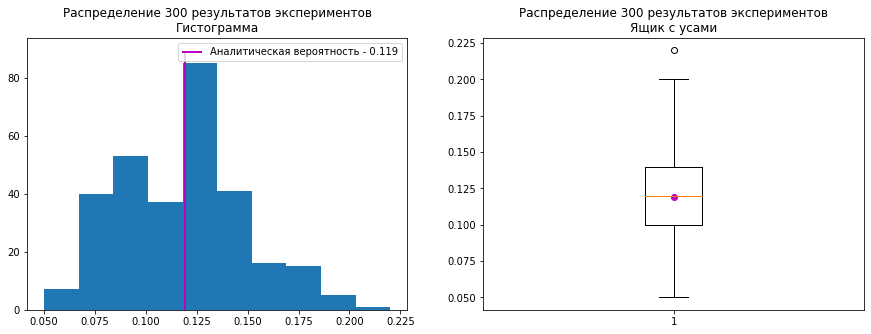

In [76]:
# Визуализация результатов экспериментов
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].hist(results_1)
ax[0].vlines(x = analytical_result_1,
          ymin = 0,
          ymax = ax[0].get_ylim()[1],
          color = 'm',
          linewidth = 2,
          label = f'Аналитическая вероятность - {analytical_result_1}')
ax[1].boxplot(results_1)
ax[1].scatter(x=1, y=analytical_result_1, c='m', label=f'Аналитическая вероятность - {analytical_result_1}')

ax[0].title.set_text(f"Распределение {n_experiments_1} результатов экспериментов\nГистограмма")
ax[0].legend(loc="upper right")
ax[1].title.set_text(f"Распределение {n_experiments_1} результатов экспериментов\nЯщик с усами")
#ax[1].legend(loc="lower left")
plt.show()

In [77]:
# Проверка на вхождение в доверительный интервал (90% от всех наблюдений)
alpha = 0.9
x_in_confidence_interval_1 = lambda x, s, a: s.quantile(0.5-a/2) <= x <= s.quantile(0.5+a/2)
in_interval_1 = x_in_confidence_interval_1(analytical_result_1, results_1, alpha)

print(f"Доверительный интервал (при alpha={alpha}): {results_1.quantile(0.5-alpha/2):.4f} - {results_1.quantile(0.5+alpha/2):.4f}\n"\
    f"{analytical_result_1} - {'входит в интервал' if in_interval_1 else 'не входит в интервал'}")

Доверительный интервал (при alpha=0.9): 0.0700 - 0.1705
0.119 - входит в интервал


##### Вывод:

Аналитическая вероятность входит в доверительный интервал, при:
1. alpha = 0.9
2. Кол-во экспериментов = 300
3. Кол-во наблюдений в каждом эксперименте = 100

Данный эксперимент **подтверждает** аналитический рельтат.

## Задача 3

Мастер, имея 10 деталей, из которых 3 – нестандартных, проверяет детали одну за другой, пока ему не попадется стандартная. Какова вероятность, что он проверит ровно две детали?

В интернете полученный аналитически ответ 7/30 или 0.23333. Подтверждается ли он эксперементально?

In [78]:
random_seed = 1
analytical_result_2 = 0.23333

In [79]:
def create_details_line(seed:int, n_details:int=10, n_not_standart_details:int=3) -> list:
    """ 
    Функция формирует и возвращает массив целых чисел (0 и 1), 
    представляемый 'последовательностью деталей', где 0 - стандартная деталь, 1 - не стандартная деталь.
    """
    n_standart_details = n_details - n_not_standart_details
    details_line = []
    for i in range(n_details):
        details_line.append(int(i<n_not_standart_details))
    np.random.seed(seed)     
    np.random.shuffle(details_line)
    return details_line

In [80]:
def experiment_2(details_line_create_func:object, n_observations:int, seed:int) -> float:
    """
    Функция воспроизводит эксперимент со случайными взятиями фруктов из корзины, 
    формируя датафрейм по полученным исходам,
    и возвращает долю интересующих наблюдений от всей сгенерированной выборки.
    """
    df = pd.DataFrame([details_line_create_func(random_seed+seed+i) for i in range(n_observations)], 
                      columns=["x0","x1","x2","x3","x4","x5","x6","x7","x8","x9"])
    n_relevant_observations = df[(df.x0==1) & (df.x1==0)].shape[0]
    return (n_relevant_observations / n_observations)

In [81]:
# Результат эксперимента для 30 наблюдений
n_observations_2 = 30
experiment_2(create_details_line, n_observations_2, random_seed)

# 0.06666666666666667

0.06666666666666667

In [82]:
# Статистические показатели по 1000 экспериментам
n_observations_2 = 30
n_experiments_2 = 1000
results_2 = pd.Series([experiment_2(create_details_line, n_observations_2, i) for i in tqdm(range(n_experiments_2))])


print(f"Средний результат - {results_2.mean():.5f}\n"\
      f"Стандартное отклонение - {results_2.std():.5f}\n"\
      f"Минимальное значение - {results_2.min():.5f}\n"\
      f"Максимальное значение - {results_2.max():.5f}")

# Средний результат - 0.22047
# Стандартное отклонение - 0.07075
# Минимальное значение - 0.06667
# Максимальное значение - 0.43333


Средний результат - 0.22047
Стандартное отклонение - 0.07075
Минимальное значение - 0.06667
Максимальное значение - 0.43333


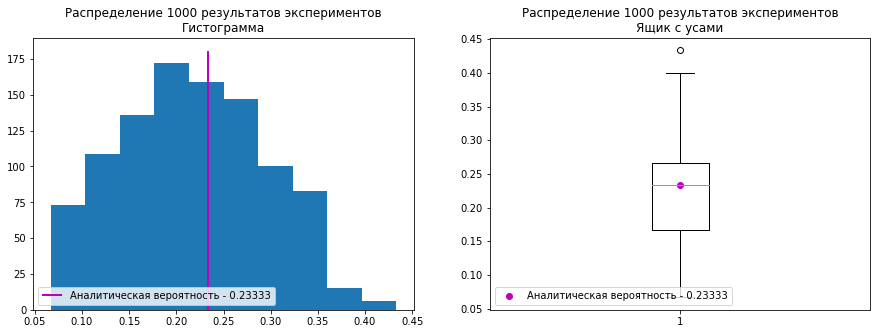

In [83]:
# Визуализация результатов экспериментов
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].hist(results_2)
ax[0].vlines(x = analytical_result_2,
          ymin = 0,
          ymax = ax[0].get_ylim()[1],
          color = 'm',
          linewidth = 2,
          label = f'Аналитическая вероятность - {analytical_result_2}')
ax[1].boxplot(results_2)
ax[1].scatter(x=1, y=analytical_result_2, c='m', label=f'Аналитическая вероятность - {analytical_result_2}')

ax[0].title.set_text(f"Распределение {n_experiments_2} результатов экспериментов\nГистограмма")
ax[0].legend(loc="lower left")
ax[1].title.set_text(f"Распределение {n_experiments_2} результатов экспериментов\nЯщик с усами")
ax[1].legend(loc="lower left")
plt.show()

In [84]:
# Проверка на вхождение в доверительный интервал (90% от всех наблюдений)
alpha = 0.9
x_in_confidence_interval_2 = lambda x, s, a: s.quantile(0.5-a/2) <= x <= s.quantile(0.5+a/2)
in_interval_2 = x_in_confidence_interval_2(analytical_result_2, results_2, alpha)

print(f"Доверительный интервал (при alpha={alpha}): {results_2.quantile(0.5-alpha/2):.4f} - {results_2.quantile(0.5+alpha/2):.4f}\n"\
    f"{analytical_result_2} - {'входит в интервал' if in_interval_2 else 'не входит в интервал'}")

Доверительный интервал (при alpha=0.9): 0.1000 - 0.3333
0.23333 - входит в интервал


##### Вывод:

Аналитическая вероятность входит в доверительный интервал, при:
1. alpha = 0.9
2. Кол-во экспериментов = 1000
3. Кол-во наблюдений в каждом эксперименте = 30

Данный эксперимент **подтверждает** аналитический рельтат.